In [1]:
import numpy.random as rand
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge as ridge
from sklearn.linear_model import Lasso as lasso
from sklearn.linear_model import LinearRegression as ols


from sklearn.ensemble import RandomForestRegressor as rfr
from sklearn.tree import DecisionTreeRegressor as reg_tree
from sklearn.ensemble import AdaBoostRegressor as ada_reg
from sklearn.ensemble import GradientBoostingRegressor as gbr
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split
import copy

import matplotlib

# read data from R

In [28]:
import rpy2.robjects as ro
readRDS = ro.r['readRDS']

path = 'C:/integraion_RCT_and_Obs/integration_RCT_and_Obs/01_data/data/0805/narrow_1d_n550_1.obj'
obj = readRDS(path) 
obj_kes_list = obj.names 

In [43]:
print(obj_kes_list)

[1] "X"    "Y"    "Tau"  "Base" "U"    "Z"    "ID"   "info"



In [ ]:
X_full   = np.array(obj[0])
Y_full   = np.array(obj[1])
Tau_full = np.array(obj[2])
T_full   = np.array(obj[5])
ID       = np.array(obj[6])

# sepalate  RCT and Obs
X   = X_full[ID == "O"]
X_E = X_full[ID == "R"]
Y   = Y_full[ID == "O"]
Y_E = Y_full[ID == "R"]
T   = T_full[ID == "O"]
T_E = T_full[ID == "R"]

In [62]:
X_E = np.random.uniform(-1,1, size=(m,))
U_E = np.random.normal(0,1, size=(m,))
T_E = rand.randint(0,2,(m,))
Y_E = np.vectorize(ft)(T_E, X_E) + U_E + 0.5* np.random.normal(size=U_E.shape)
print(X_E.shape, U_E.shape, T_E.shape, Y_E.shape)

(1000,) (1000,) (1000,) (1000,)


In [ ]:
X_E[T_E>0].reshape(-1,1), Y_E[T_E>0]

numpy.ndarray

# DGP

In [29]:
m = 1000
d = 1

In [30]:
T = rand.randint(0,2,(m,))
# T = T.ravel()
T.shape

(1000,)

In [32]:
mu_0 = 0
mu_1 = 0
nu_0 = -0.25
nu_1 = +0.25
kappa = 0.50

In [33]:
alpha = [1,2]
beta = [1,2]
gamma = [0.5,0.75]

ft = lambda t,x : alpha[t] + beta[t]*x + gamma[t]*x*x

In [35]:
mean = [[mu_0, nu_0],[mu_1, nu_1]]
cov = (2*T-1)*kappa
X, U = np.zeros(cov.shape), np.zeros(cov.shape[0])
for i in range(T.shape[0]):
    # int(cov[i])
    X[i], U[i] = np.random.multivariate_normal(mean[T[i]], [[1, cov[i]],[cov[i],1]]).T
print(X.shape,U.shape,cov.shape)

(1000,) (1000,) (1000,)


In [36]:
Y = np.vectorize(ft)(T,X) + U + 0.5* np.random.normal(size=U.shape)
Y.shape

(1000,)

In [53]:
X_E = np.random.uniform(-1,1, size=(m,))
U_E = np.random.normal(0,1, size=(m,))
T_E = rand.randint(0,2,(m,))
Y_E = np.vectorize(ft)(T_E, X_E) + U_E + 0.5* np.random.normal(size=U_E.shape)
print(X_E.shape, U_E.shape, T_E.shape, Y_E.shape)

(1000,) (1000,) (1000,) (1000,)


In [11]:
from lin_eta_gaussianU import generate_data_with_linear_eta

# model

In [50]:
regs = [rfr(n_estimators=i) for i in [10, 20, 40, 60, 100, 150, 200]]
regs += [reg_tree(max_depth=i) for i in [5, 10, 20, 30, 40, 50]]
regs += [ada_reg(n_estimators=i) for i in [10, 20, 50, 70, 100, 150, 200]]
regs += [gbr(n_estimators=i) for i in [50, 70, 100, 150, 200]]

In [66]:
def get_best_for_data(X, Y, regs):
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2) # doesn't change X
    val_errs = []
    models = []
    for reg in regs:
        model = copy.deepcopy(reg)
        model.fit(x_train, y_train)
        val_errs.append(mse(y_test, model.predict(x_test)))
        models.append(copy.deepcopy(model))
    min_ind = val_errs.index(min(val_errs))
    print(str(model)[:40], val_errs[min_ind])
    return copy.deepcopy(models[min_ind])
    

In [89]:
f1pred_exp = get_best_for_data(X_E[T_E>0].reshape(-1,1), Y_E[T_E>0], regs)
f0pred_exp = get_best_for_data(X_E[T_E==0].reshape(-1,1), Y_E[T_E==0], regs)
f1pred_obs = get_best_for_data(X[T>0].reshape(-1,1), Y[T>0], regs)
f0pred_obs = get_best_for_data(X[T==0].reshape(-1,1), Y[T==0], regs)

# f0pred_exp.fit(X[T==0].reshape(-1, 1),Y[T==0])
# f1pred_obs.fit(X_E[T_E>0].reshape(-1, 1),Y_E[T_E>0])
# f0pred_obs.fit(X_E[T_E==0].reshape(-1, 1),Y_E[T_E==0])

GradientBoostingRegressor(n_estimators=2 2.5752782994860315
GradientBoostingRegressor(n_estimators=2 1.2301654416857166
GradientBoostingRegressor(n_estimators=2 1.060875846659241
GradientBoostingRegressor(n_estimators=2 1.625002326202793


In [90]:
X_full = np.hstack((X, X_E))
print(X_full.shape)
Y_full = np.hstack((Y, Y_E))
print(Y_full.shape)
T_full = np.hstack((T, T_E))
neg_T = 2*T-1
neg_T_full = 2*T_full -1
exp_filter = np.array([False]*int(X_full.shape[0]/2) + [True]*int(X_full.shape[0]/2) )
print(exp_filter.shape)

(550,)
(550,)
(550,)


In [91]:
omega = f1pred_obs.predict(X_E.reshape(-1,1)) - f0pred_obs.predict(X_E.reshape(-1,1)) 
tau = f1pred_exp.predict(X_E.reshape(-1,1)) - f0pred_exp.predict(X_E.reshape(-1,1))
print(omega.shape, tau.shape)

(150,) (150,)


In [92]:
omega_O = f1pred_obs.predict(X.reshape(-1,1)) - f0pred_obs.predict(X.reshape(-1,1)) 
tau_O = f1pred_exp.predict(X.reshape(-1,1)) - f0pred_exp.predict(X.reshape(-1,1))
print(omega.shape, tau.shape)

(150,) (150,)


In [93]:
eta_est = tau - omega
print(eta_est.shape)
eta_est_O = tau_O - omega_O
print(eta_est_O.shape)

(150,)
(400,)


In [94]:
# eta_ridge= ridge()
eta_ridge = get_best_for_data(X_E.reshape(-1, 1), eta_est, [ridge(alpha=a) for a in [1e-10]])# , 1e-5, 1e-4]])# ,1e-2,1,1e+2,1e+4, 1e+5]])
print(mse(eta_est, eta_ridge.predict(X_E.reshape(-1, 1))))
# print(mse(eta, -6*kappa*X_full))

Ridge(alpha=1e-10) 0.8888393935053877
0.7148862503851928


In [95]:
mu_T_full = np.array([mean[t][0] for t in T_full]).ravel()
nu_T_full = np.array([mean[t][1] for t in T_full]).ravel()
print(mu_T_full.shape, nu_T_full.shape)

(550,) (550,)


In [96]:
print(eta_ridge.coef_, eta_ridge.intercept_)
lambda_1 = nu_1 - kappa*mu_1
lambda_0 = nu_0 + kappa*mu_0

print(-2*kappa, -lambda_1 + lambda_0)

[0.4908413] -0.6395503142819403
-1.0 -0.5


# plot

In [105]:
tau   = Tau_full[ID == "O"]
tau_E = Tau_full[ID == "R"]

In [126]:
test_X = np.arange(-3,3,0.01)
true_test_tau = test_X * test_X

omega =  f1pred_obs.predict(test_X.reshape(-1, 1)) - f0pred_obs.predict(test_X.reshape(-1, 1))
eta   = eta_ridge.predict(test_X.reshape(-1, 1))

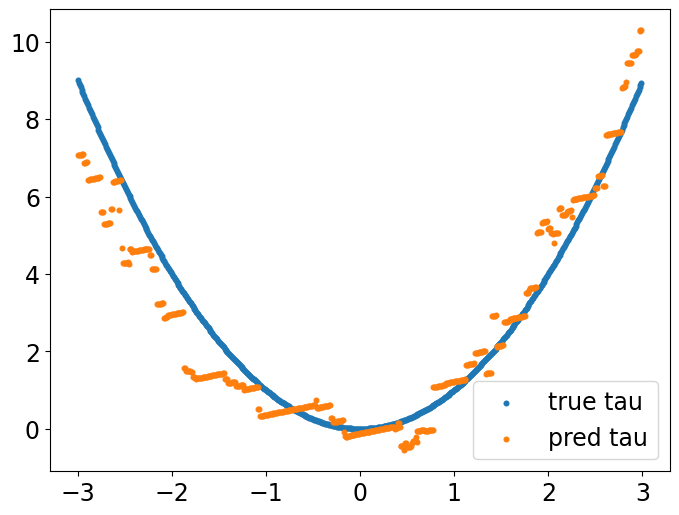

In [127]:
plt.figure(figsize=(8,6))
plt.scatter(test_X, true_test_tau, label='true tau', s=11)
plt.scatter(test_X, omega + eta , label='pred tau', s=11)
plt.legend()
plt.show()

In [128]:
from sklearn.metrics import mean_squared_error as mse

In [129]:
mse(true_test_tau,  omega + eta)

0.694222119051742